## Lecture 8: Estimating HANK


NBER Heterogeneous-Agent Macro Workshop

Adrien Auclert, Michael Cai, and Matthew Rognlie

Spring 2023

Import standard scientific Python packages and SSJ:

In [1]:
import numpy as np
from scipy import optimize, signal
import pandas as pd

import sequence_jacobian as sj

From `estimation/routines.py` we'll also import some extra routines for simulation, computing priors, and historical shock decomposition of time series:

In [2]:
from estimation.routines import simulate, log_priors

From `estimation/plots.py` we'll import some helper code for plotting:

In [3]:
from estimation.plots import plot_timeseries, plot_impulses, plot_decomp

Finally, we'll import a standard HA Model with real bonds, a gradual tax adjustment rule in response to fiscal shocks, and a Taylor rule for monetary policy. For details, you can look at the (brief) specification of the model in `estimation/model.py`.

In [4]:
from estimation.model import ha

## Calibration and model setup

In [5]:
calibration = {'eis': 0.5,  # elasticity of intertemporal substitution
               'frisch': 0.5,  # labor supply elasticity
               'markup_ss': 1.015,  # steady state markup
               'phi_pi': 1.5,  # Taylor coefficient on inflation
               'kappa_w': 0.2,  # slope of the wage Phillips curve
               'phi_T': 0.1,  # adjustment coefficient in tax rule
               'rho_e': 0.92,  # persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,  # standard deviation fo idiosyncratic productivity shocks
               'n_e': 11,  # number of productivity grid points
               'min_a': -1,  # minimum asset level on the grid
               'max_a': 1000,  # maximum asset level on the grid
               'n_a': 500,  # number of asset grid points
               'X': 1.,  # TFP
               'G': 0.,  # exogenous government spending
               'B': 0.,  # government debt level
               'Tss': 0.,  # steady state government taxes
               'ishock': 0.}  # monetary policy shock

# Steady state values for endogenous variables
calibration['r'] = calibration['rss'] = 0.01
calibration['pi'] = 0.
calibration['Y'] = 1.

In [6]:
unknowns_ss = {"beta": 0.8, "vphi": 0.8}
targets_ss = ["asset_mkt", "piwres"]
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)

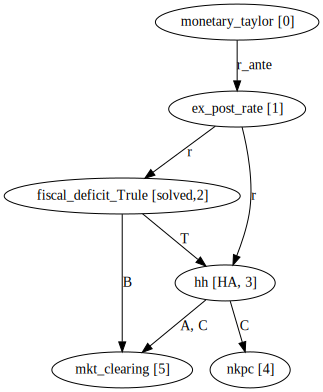

In [7]:
sj.drawdag(ha)

In [8]:
ss['beta']

0.8233548425126794

We'll assume that the Taylor rule intercept `ishock`, the TFP parameter `X`, and government spending `G` all follow AR(1) processes, and we'll be interested in what happens to three outcome variables: inflation `pi`, output `Y`, and the nominal interest rate `i`.

First, let's solve for the GE Jacobian of these outcomes with respect to the inputs that are shocked. This will prove useful later as well.

In [9]:
unknowns = ['Y', 'pi']
targets = ['asset_mkt', 'piwres']
inputs = ['ishock', 'X', 'G']
outputs = ['pi', 'Y', 'i']
T = 500

G = ha.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

Now we'll specify the persistences and standard deviation of the shocks, calculate the impulse response of each shocked variable to its one-standard-deviation innovation, and then compose each with `G` to get the impulse responses of the outcome variables, for which we'll maintain a list.

In [10]:
sigmas = {'ishock': 1, 'X': 0.5, 'G': 0.2}
rhos = {'ishock': 0.7, 'X': 0.8, 'G': 0.7}
impulses = {}
for i in inputs:
    own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
    impulses[i] = G @ own_shock

Now if we feed the list of impulse responses to our independent shocks to our `simulate` function, it will give us simulations of whatever length we want.

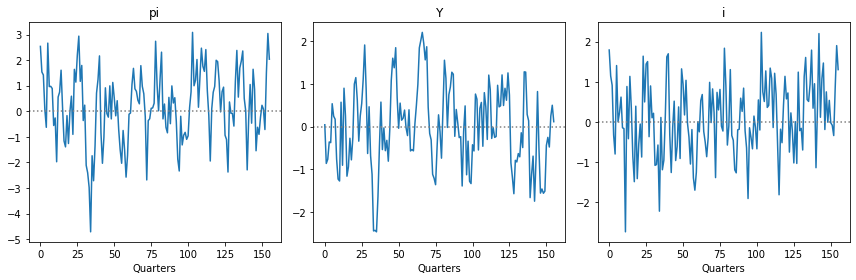

In [11]:
# Simulate series of pi, Y and i
T_sim = 156  # 39 years, as in the original SW (2007) sample
data_simul = simulate(list(impulses.values()), outputs, T_sim)
plot_timeseries(data_simul, (1,3), figsize=(12, 4))

## Evaluating the log-likelihood
From here, we will explain step-by-step how to compute the log-likelihood, which can then be added to the log of the priors we specified to obtain the log-posterior, over which we will optimize to find the modal parameters.

First, we'll solve for the log-likelihood at the $\sigma$s and $\rho$s we've chosen so far.

### Step 1: compute the MA representation of outputs with respect to shocks
This step constructs the $MA(\infty)$ representation of the endogenous sequence $dX_t$ with respect to the exogenous shock $dZ_t$

In particular, if the $MA(\infty)$ representation of the exogenous shock is given by

$$
dZ_t = \sum_{s = 0}^\infty M^Z_s \epsilon_{t-s}
$$

Then under certainty equivalence, $dX_t$ follows

$$
dX_t = \sum_{s = 0}^\infty M^X_s \epsilon_{t - s}
$$

where the GE Jacobian, $\mathcal{G}$ gives us the mapping
$$
M^X = \mathcal{G}^{X, Z} M^Z
$$


We've actually already done this when we calculated `impulses`, which can also be viewed as the $MA(\infty)$ representation of the outcome variables of interest with respect to the shocks. So for this step, we don't need to do any more for now!

### Step 2: compute the covariance matrix of the model
Given $M^X$, we can then compute the covariance matrix of the endogenous variables via the formula (letting $Y$ denote the "observable" variables, as before)

$$
\text{Cov}(dX_t, dY_{t^\prime}) = \sum_{s = 0}^\infty M^X_s (M^Y_{s + t^\prime - t})'
$$

This process is automated by the SSJ function `sj.estimation.all_covariances`, which takes in the set of all $M$s as a $T\times n_O \times n_Z$ array, where the first dimension is time, the second dimension is each output variable, and the third dimension is each shock. We can manually assemble it in this form:

In [12]:
M = np.empty((T, 3, 3))
for no, o in enumerate(outputs):
    for ns, s in enumerate(inputs):
        M[:, no, ns] = impulses[s][o]

and then call it to get `Sigma`, which is a $T\times n_O \times n_O$ array, where in general `Sigma[s,o1,o2]` gives the covariance between output `o1` at time $t$ and output `o2` at time $t'=t+s$.

Note that this function also takes a second argument `sigmas` of the standard deviations of each shock, but we have already scaled our impulses by the standard deviation, so we should just use a vector of ones here:

In [13]:
Sigma = sj.estimation.all_covariances(M, np.ones(3))

### Step 3: compute log-likelihood
Denote the stacked covariance matrix as $\mathbf{V}(\theta)$ to clarify that it is a function of the parameter vector, $\theta$.

The log-likelihood can then be computed, assuming Gaussian innovations to the shock processes, by stacking the data into the vector $\mathbf{Y}$ and calculating (ignoring constant terms that won't change with the data or parameters and only depend on dimension):

$$
\mathcal{L}(\mathbf{Y}; \theta) = -\frac{1}{2} \log \text{det} \mathbf{V}(\theta) - \frac{1}{2} \mathbf{Y}^\prime \mathbf{V}(\theta)^{-1} \mathbf{Y}
$$

This is implemented by the function `log_likelihood`, which takes as its second argument the `Sigma` matrix calculated above,  and as its first argument the `Y` array with the data for which we want to compute the log-likelihood. We'll manually assemble `Y`, where the first dimension is time and the second is the output:

In [14]:
Y = np.empty((T_sim, 3))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]

Then we'll apply the function. (It also takes in a third optional argument for measurement error, which we won't use.)

In [15]:
loglik = sj.estimation.log_likelihood(Y, Sigma)

### Step 4: adding the log-prior to the log-likelihood

This follows directly from Bayes' formula

$$
\log \pi(\theta; \mathbf{Y}) \propto \mathcal{L}(\mathbf{Y}; \theta) + \log \pi(\theta)
$$

To do this, we'll need to collapse our parameters (standard deviations and persistences) into a vector `theta`:

In [16]:
theta = np.array([sigmas['ishock'], rhos['ishock'], sigmas['X'], rhos['X'], sigmas['G'], rhos['G']])

and then specify priors over these parameters (where each parameter has a prior given by a 3-tuple, with the family of distribution and two parameters describing that distribution for each—in this case just a uniform over $[0,2]$ for each):

In [17]:
# Specifying priors over the exogenous shock series parameters
priors = [('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2), ('Uniform', 0, 2)]

and then use 

In [18]:
log_posterior = loglik + log_priors(theta, priors)

## Maximizing the posterior likelihood over these parameters
Now that we know how to calculate the log posterior likelihood given the data and shock process parameters, let's see if we can maximize this likelihood given the data - i.e. find the parameters at the posterior mode.

To do so, we need to consolidate the workflow above into a function that takes `theta` as an input and calculates the log posterior likelihood.

In [19]:
def log_likelihood(theta):
    # turn theta into dicts mapping input shocks to sigmas and rhos
    sigma_array, rho_array = theta.reshape(3, 2).T
    sigmas, rhos = dict(zip(inputs, sigma_array)), dict(zip(inputs, rho_array))
    
    # step 1: construct impulses to shocks, aka MA representation
    impulses = {}
    for i in inputs:
        own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
        impulses[i] = G @ own_shock
        
    # step 2: get covariances by building M array and calling .all_covariances()
    M = np.empty((T, 3, 3))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = impulses[s][o]
    
    Sigma = sj.estimation.all_covariances(M, np.ones(3))
    
    # step 3: compute log-likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    
    # step 4: add log prior to get log posterior
    return loglik + log_priors(theta, priors)

Let's verify that this gives the same answer that we just found on the same `theta`:

In [20]:
log_likelihood(theta) == log_posterior

True

Now let's use a numerical optimization routine to find the `theta` that maximizes the log posterior. To make sure the optimizer stays in a reasonable subspace, we'll first need to put some bounds on each dimension of the `theta`:

In [21]:
bounds = [(0.05, 1.5), (0.01, 0.99), (0.05, 1.5), (0.01, 0.99), (0.05, 1.5), (0.01, 0.99)]

Then call `optimize.minimize`, asking to minimize the negative of the log likelihood, putting `0.8*theta` rather than the true parameter `theta` as our initial guess to make the optimizer's life a little more difficult. Turns out that it takes a bit more than a second:

In [22]:
%time result = optimize.minimize(lambda theta: -log_likelihood(theta), 0.8*theta, bounds=bounds)

CPU times: user 1.92 s, sys: 22.8 ms, total: 1.94 s
Wall time: 980 ms


In [23]:
theta_estimate = result.x
theta_estimate

array([1.02688705, 0.70787409, 0.481081  , 0.74764711, 0.21524002,
       0.6519932 ])

Maximum difference between estimated and true parameters not too large, so this seemed to work well!

In [24]:
np.max(np.abs(theta_estimate - theta))

0.05235288762459844

We could further check to make sure that the shock process parameters are well-identified by repeating this exercise on multiple simulated time series, making sure that the distribution of estimates we obtain has a peak near the true `theta`.

## More ambitious estimation exercise: add three parameters, more realistic priors, actual US data

### Loading the data
Now we'll try to estimate the model on actual US data. In `us_data.csv`, we've stored quarterly time series obtained from Fred for (annualized) core PCE inflation `pi`, chained-dollar real GDP `Y`, and the federal funds rate `i`. Let's load this as a dataframe:

In [25]:
df = pd.read_csv('estimation/us_data.csv', index_col=0)

We want to demean the rate variables `pi` and `i`, and log and detrend GDP `Y`:

In [26]:
df['pi'] = df['pi'] - df['pi'].mean()
df['i'] = df['i'] - df['i'].mean()
df['Y'] = 100 * signal.detrend(np.log(df['Y']))

For fun, let's plot. We can see the Great Inflation, the Volcker contraction and recession, the late-90s boom, and so on:

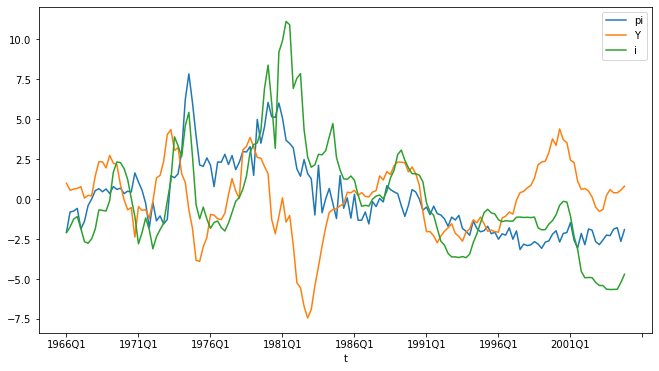

In [27]:
df.plot(figsize=(11,6));

For our log-likelihood function, let's put this data in an array `Y` like before:

In [28]:
Y = np.empty((len(df), 3))
for no, o in enumerate(outputs):
    Y[:, no] = df[o]

### Adding parameters to the estimation, more realistic priors
In addition to the shock process parameters we've been estimating, we'll now try to also estimate three parameters: the Phillips curve slope `kappa_w`, the Taylor rule slope `phi_pi`, and the speed of fiscal adjustment `phi_T`.

In [29]:
param_names = ['kappa_w', 'phi_pi', 'phi_T']

We'll also put more broadly accepted priors on our shock process parameters, with inverse gammas for the standard deviations. We'll always order the 6 shock parameters first, then the 3 model parameters:

In [30]:
priors = [('Invgamma', 0.4, 4), ('Uniform', 0, 1), ('Invgamma', 0.5, 4), ('Uniform', 0, 1), ('Invgamma', 1, 4), ('Uniform', 0, 1),
          ('Uniform', 0, 1), ('Gamma', 1.5, 0.25), ('Uniform', 0, 1)]  # shock parameters then model parameters

We'll have very permissive bounds to make sure we can find an optimum:

In [31]:
bounds = [(0.05, 10), (0.01, 0.99)] * len(inputs) + [(0.01, 0.99), (1.05, 5), (0.01, 1)]

For our guess for the parameter vector `theta` (to initialize the optimization routine), we'll use standard deviations of 1, persistences of 0.5, and then the actual steady state model values for the parameters:

In [32]:
theta_guess = np.array([1, 0.5] * len(inputs) + [ss[k] for k in param_names])

Now we need to write a somewhat more complex function that goes through the workflow of calculating the log-likelihood given parameters `theta`. The tricky part here is that, since we're now trying different model parameters, the general equilibrium Jacobian `G` will change, so we can't just use the same `G` that we already calculated.

Instead, we'll need to `G` recalculate it on every iteration where the model parameters change. But, crucially, we don't want to recalculate the household Jacobian on any of these iterations, because none of the *household* steady-state parameters are changing. So we'll calculate that ahead of time and supply it to our routine to calculate `G`, so it can skip that work.

In [33]:
J_ha = ha['hh'].jacobian(ss, inputs=['r', 'Y', 'T'], T=T)

We also don't want to recalculate `G` if the solver isn't changing the model parameters, because that's wasteful. So we'll keep track of the most recent parameters and general equilibrium Jacobian G. We'll do this by mutating an entry in a list (this is an easy way to make sure we're actually sharing something global):

In [34]:
last_params = [np.zeros(3)]
last_G = [None]

Now let's write our log-likelihood function!

In [35]:
def log_likelihood_advanced(theta):
    # turn theta into dicts mapping input shocks to sigmas, rhos, and params
    sigma_array, rho_array = theta[:6].reshape(3, 2).T
    param_array = theta[6:]
    sigmas, rhos, params = dict(zip(inputs, sigma_array)), dict(zip(inputs, rho_array)), dict(zip(param_names, param_array))
    
    # step 0: if params are different from last time, recalculate G, otherwise use same
    if not np.array_equal(last_params[0], param_array):
        ss_new = ss.copy()
        ss_new.update(params)
        G = ha.solve_jacobian(ss_new, unknowns, targets, inputs, outputs, Js={'hh': J_ha}, T=T)
        last_params[0] = param_array
        last_G[0] = G
    else:
        G = last_G[0]
    
    # step 1: construct impulses to shocks, aka MA representation
    impulses = {}
    for i in inputs:
        own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
        impulses[i] = G @ own_shock
        
    # step 2: get covariances by building M array and calling .all_covariances()
    M = np.empty((T, 3, 3))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = impulses[s][o]
    
    Sigma = sj.estimation.all_covariances(M, np.ones(3))
    
    # step 3: compute log-likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    
    # step 4: add log prior to get log posterior
    return loglik + log_priors(theta, priors)

And now we'll optimize just like before!

In [36]:
%time result = optimize.minimize(lambda theta: -log_likelihood_advanced(theta), theta_guess, bounds=bounds)
theta = result.x

CPU times: user 2min 23s, sys: 16.1 s, total: 2min 39s
Wall time: 1min 22s


In [37]:
result.success

True

In [38]:
# use same code as in log-likelihood function to unpack the thetas
sigma_array, rho_array = theta[:6].reshape(3, 2).T
param_array = theta[6:]
sigmas, rhos, params = dict(zip(inputs, sigma_array)), dict(zip(inputs, rho_array)), dict(zip(param_names, param_array))
print(f'sigmas = {sigmas}')
print(f'rhos = {rhos}')
print(f'params = {params}')

sigmas = {'ishock': 2.120680643680333, 'X': 0.6169398326127478, 'G': 1.4489986536244315}
rhos = {'ishock': 0.3963360682150984, 'X': 0.952755789423365, 'G': 0.8068201825150272}
params = {'kappa_w': 0.6681635859628037, 'phi_pi': 1.7845223789297195, 'phi_T': 0.04097728918144732}


## Post-estimation results

After obtaining the modal parameters, we can compute a number of useful results, including impulse responses of the observed variables, $\pi, Y, i$, a decomposition of the share of the observable variables' variance that each of the exogenous shocks account for, and a decomposition of the forecast errors at each horizon that each of the exogenous shocks account for.

First, let's just get the G matrix for a broader set of variables of interest.

In [39]:
# Compute HA model jacobian given estimated parameters
ss_est = ss.copy()
ss_est.update(params)
varlist = ['C','Y','N','B','T','pi','piw','i','r_ante']

G_est = ha.solve_jacobian(ss_est, unknowns, targets, inputs, varlist,  Js={'hh': J_ha}, T=T)

__Impulse response at the mode__

First let's get all the impulses from our shocks like before:

In [40]:
impulses = {}
for i in inputs:
    own_shock = {i: sigmas[i] * rhos[i]**np.arange(T)}
    impulses[i] = G_est @ own_shock

Now let's plot these impulses using a simple plotting function:

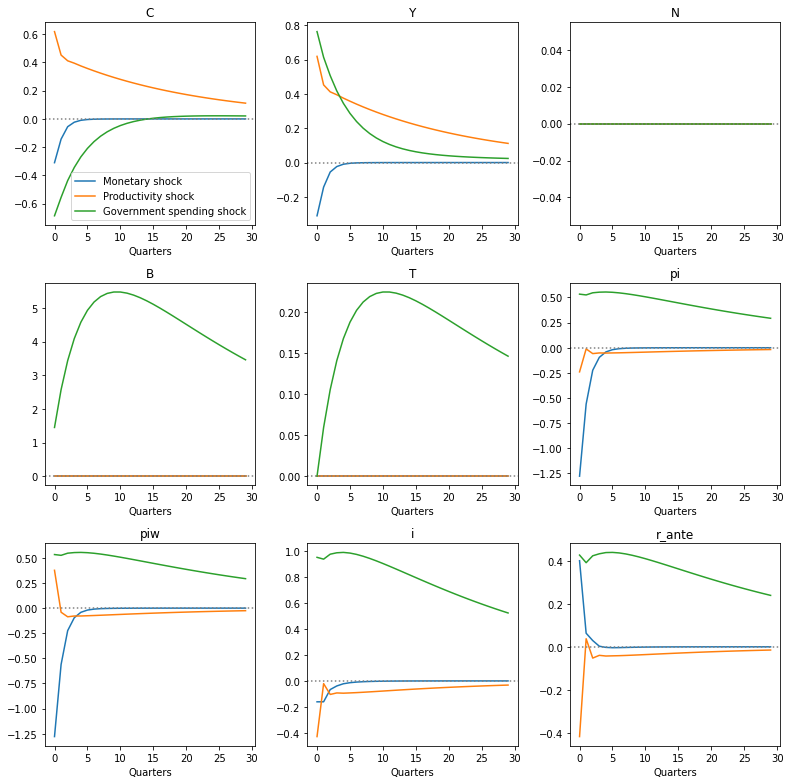

In [41]:
labels = {'ishock': 'Monetary shock',
          'X': 'Productivity shock',
          'G': 'Government spending shock'}
plot_impulses(impulses, labels, varlist, (3,3), T=30, figsize=(11,11))

**Forecast error variance decomposition**

In [42]:
# cumulative sum of squares to find forecast error variance contribution of
# each shock at each horizon
FEV = np.cumsum(M ** 2, axis=0)

# sum across all shocks to get total FEV for each output
FEV_sum = np.sum(FEV, axis=2)

# use this to normalize contributions of each shock, so we plot percentages of FEV
# at each horizon that each shock contributes
FEV_norm = FEV / FEV_sum[..., np.newaxis]

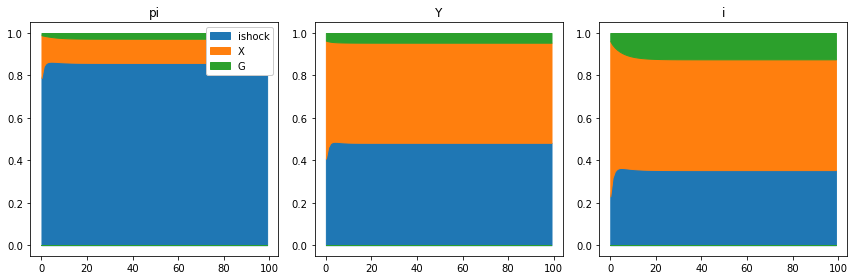

In [43]:
horizon = 100
plot_decomp(FEV_norm[:horizon], None, inputs, outputs, np.arange(horizon), figsize=(12,4))